### 1. Warmup

In [51]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from collections import Counter

import torch

In [22]:
seed = 761
torch.manual_seed(seed)

In [23]:
def sample_data():
    count = 10000
    rand = np.random.RandomState(0)
    a = 0.3 + 0.1 * rand.randn(count)
    b = 0.8 + 0.05 * rand.randn(count)
    mask = rand.rand(count) < 0.5
    samples = np.clip(a * mask + b * (1 - mask), 0.0, 1.0)
    return np.digitize(samples, np.linspace(0.0, 1.0, 100))

In [24]:
data = sample_data()
print(data)

[48 76 88 ... 35 30 43]


In [25]:
train_dataset, val_dataset = train_test_split(data, train_size=0.8, random_state=seed)
train_dataset, test_dataset = train_test_split(train_dataset, train_size=0.75, random_state=seed)

print("Train size:", len(train_dataset))
print("Validation size:", len(val_dataset))
print("Test size:", len(test_dataset))

Train size: 6000
Validation size: 2000
Test size: 2000


In [26]:
num_epochs = 200
batch_size = 1000

In [27]:
def NLLLoss(theta, batch):
    size = len(batch)
    output = torch.exp(theta) / torch.sum(torch.exp(theta))
    probs = torch.gather(output, dim=0, index=batch)
    loss = torch.sum(-torch.log2(probs)) / size
    return loss

In [28]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=len(val_dataset), shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=len(test_dataset), shuffle=False)

In [29]:
theta = torch.zeros(100, requires_grad=True)
optimizer = torch.optim.Adam([theta])

In [30]:
train_loss_vals = []
val_loss_vals_x = []
val_loss_vals_y = []

for epoch in range(num_epochs):
    for idx, train_batch in enumerate(train_loader):
        loss = NLLLoss(theta, train_batch)
        loss.backward()
        optimizer.step()
        train_loss_vals.append(loss.item())

    if (epoch + 1) % 20 == 0 :
        print(f'Epoch {epoch + 1}/{num_epochs}, step: {len(train_loss_vals)}, loss: {loss.item()}')

    val_batch = next(iter(val_loader))  
    val_loss = NLLLoss(theta, val_batch)

    val_loss_vals_x.append(len(train_loss_vals))
    val_loss_vals_y.append(val_loss.item())

Epoch 20/200, step: 120, loss: 6.452997207641602
Epoch 40/200, step: 240, loss: 6.270207405090332
Epoch 60/200, step: 360, loss: 6.146415710449219
Epoch 80/200, step: 480, loss: 6.034366130828857
Epoch 100/200, step: 600, loss: 5.992528438568115
Epoch 120/200, step: 720, loss: 5.910437107086182
Epoch 140/200, step: 840, loss: 5.930117607116699
Epoch 160/200, step: 960, loss: 5.826674938201904
Epoch 180/200, step: 1080, loss: 5.897929668426514
Epoch 200/200, step: 1200, loss: 5.863279342651367


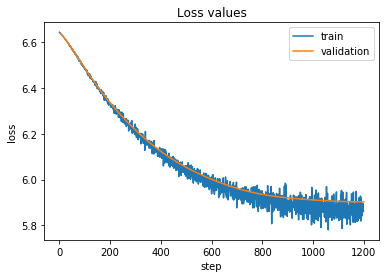

In [33]:
plt.title("Loss values")
plt.xlabel('step')
plt.ylabel('loss')

train_x_vals = [i for i in range(len(train_loss_vals))]
train_y_vals = [train_loss_vals[k] for k in train_x_vals]

plt.plot(train_x_vals, train_y_vals, label='train')
plt.plot(val_loss_vals_x, val_loss_vals_y, label='validation')

plt.legend()
plt.show()

In [38]:
test_batch = next(iter(test_loader))  
test_loss = NLLLoss(theta, test_batch)
print("Test loss:", test_loss.item())

Test loss: 5.875157356262207


In [54]:
random_sample = np.random.choice(range(1, 101), size=1000, p=theta_vec_exp)
random_sample_counts = Counter(random_sample)
random_sample_freq_probs = [random_sample_counts[k] for k in sorted(random_sample_counts.keys())]

plt.title("Resampled Data Distribution (1)")
plt.xlabel("x")
plt.ylabel("Probability by Frequency")
plt.bar(range(1, len(random_sample_freq_probs)+1), random_sample_freq_probs)
plt.show()

SyntaxError: invalid syntax (<ipython-input-54-269b771bcbd8>, line 5)

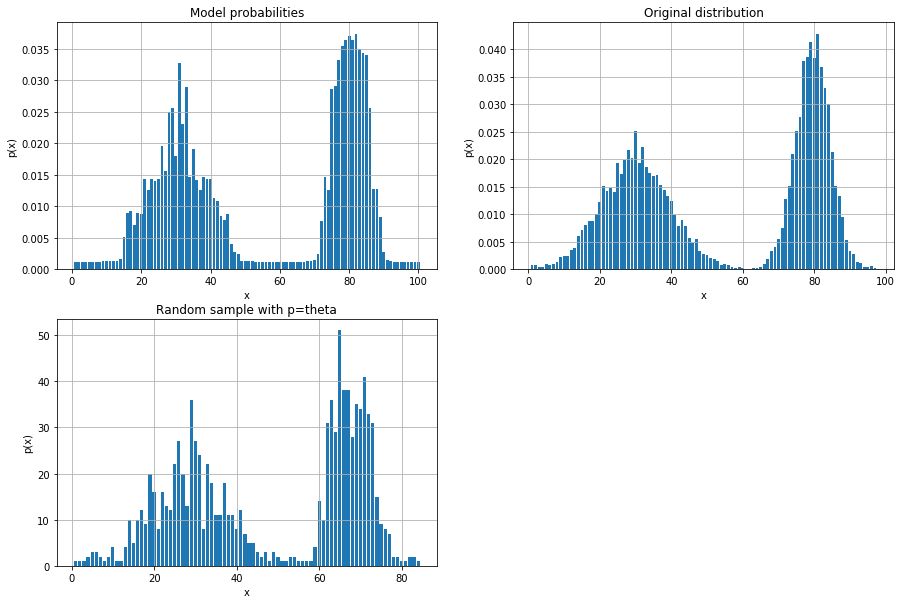

In [60]:
theta_softmax = torch.exp(theta) / torch.sum(torch.exp(theta))
probs = theta_softmax.detach().numpy()

plt.figure(figsize=(15, 10))
plt.subplot(221)
plt.title("Model probabilities")
plt.xlabel("x")
plt.ylabel("p(x)")
plt.bar(range(1, 101), probs)
plt.grid(True)

plt.subplot(222)
plt.title("Original distribution")
plt.xlabel("x")
plt.ylabel("p(x)")
counts = Counter(data)
data_size = len(data)
sorted_keys = sorted(counts.keys())
freqs = [counts[i] / data_size for i in sorted_keys]
plt.bar(range(1, len(freqs) + 1), freqs)
plt.grid(True)

plt.subplot(223)
plt.title("Random sample with p=theta")
plt.xlabel("x")
plt.ylabel("p(x)")
sample = np.random.choice(range(1, 101), size=1000, p=probs)
counts = Counter(sample)
sorted_keys = sorted(counts.keys())
freqs = [counts[i] for i in sorted_keys]
plt.bar(range(1, len(freqs)+1), freqs)
plt.grid(True)